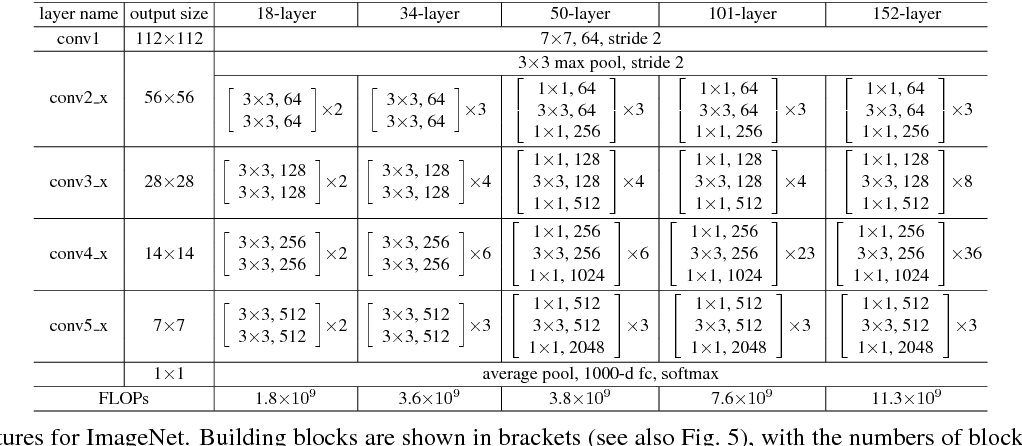

In [82]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

In [83]:
class Block(layers.Layer):
  def __init__(self,intermediate_channels, stride=(1,1), identity_downsample=None):
    super(Block, self).__init__()
    self.expansion=4
    self.padding0 = layers.ZeroPadding2D(padding=(0,0)) 
    self.padding1 = layers.ZeroPadding2D(padding=(1,1))
    self.padding2 = layers.ZeroPadding2D(padding=(2,2)) 
    self.padding3 = layers.ZeroPadding2D(padding=(3,3)) 

    self.conv1 = layers.Conv2D(intermediate_channels, kernel_size=(1,1), strides=(1,1), padding="VALID")
    self.bn1 = layers.BatchNormalization()
    self.conv2 = layers.Conv2D(intermediate_channels,kernel_size=(3,3), strides=stride,padding="VALID")    
    self.bn2 = layers.BatchNormalization()
    self.conv3 = layers.Conv2D(intermediate_channels* self.expansion,kernel_size=(1,1), strides=(1,1), padding="VALID")
    self.bn3 = layers.BatchNormalization()
    self.relu = layers.ReLU()
    self.identity_downsample = identity_downsample
    self.stride = stride

  def call(self, inputs):
    identity = tf.identity(inputs)

    x = self.padding0(inputs)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.padding1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.padding0(x)
    x = self.conv3(x)
    x = self.bn3(x)

    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)
    
    x = x + identity
    x = self.relu(x)

    return x


In [84]:
class ResNet(keras.Model):
  def __init__(self,Block, ls, num_classes):
    super(ResNet,self).__init__()
    self.ls = ls
    self.in_channels = 64
    self.pad3 = layers.ZeroPadding2D(padding=(3,3))
    self.pad1 = layers.ZeroPadding2D(padding=(1,1))

    self.conv1 = layers.Conv2D(64,kernel_size=7, strides=(2,2), padding="VALID")
    self.bn1 = layers.BatchNormalization()
    self.relu = layers.ReLU()
    self.maxpool = layers.MaxPool2D(pool_size=3, strides=(2,2), padding="VALID")


    # RESNET BLOCKS
    self.layer1 = self.create_layers(number_of_rb=ls[0], intermediate_channels=64,   stride=(1,1))
    self.layer2 = self.create_layers(number_of_rb=ls[1], intermediate_channels=128, stride=(2,2))
    self.layer3 = self.create_layers(number_of_rb=ls[2], intermediate_channels=256, stride=(2,2))
    self.layer4 = self.create_layers(number_of_rb=ls[3], intermediate_channels=512, stride=(2,2))

    self.avgPool = layers.AveragePooling2D(pool_size=(1, 1))

    self.fc = layers.Dense(num_classes)


  def create_layers(self,number_of_rb, intermediate_channels, stride):
    identity_downsample = None
    c_layers = []
    if stride !=1 or  self.in_channels!= intermediate_channels * 4:
      identity_downsample = keras.Sequential([layers.Conv2D(filters=intermediate_channels*4,
                                                            kernel_size=(1,1),
                                                            strides=stride,
                                                            padding="VALID"),
                                              layers.BatchNormalization()])
      
    c_layers.append(Block(intermediate_channels, stride, identity_downsample))

    self.in_channels= intermediate_channels*4

    for i in range(number_of_rb-1):
      c_layers.append(Block(intermediate_channels))
    
    return keras.Sequential(c_layers)

  def call(self, inputs):
    x = self.pad3(inputs)
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pad1(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avgPool(x)
    x = self.fc(layers.Flatten()(x))
    return x

In [85]:
def ResNet50(num_classes=1000):
    return ResNet(Block, ls=[3, 4, 6, 3], num_classes=1000)

In [90]:
net = ResNet50(num_classes=1000)
x = tf.random.uniform((4,224, 224,3))

In [91]:
y = net(x)

In [94]:
print(y.shape)

(4, 1000)
